## Diabetes Classification

The objective of this analysis is to understand patient factors that may potentially contribute to diabetes, and determine whether diabetes can be predicted using patient demographic and health factors.

In [1]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold
import missingno as msno

In [2]:
# import data
diabetes_data = pd.read_csv('diabetes_patients.csv')

In [3]:
# verify data
diabetes_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## Exploratory Data Analysis (EDA)


In [4]:
# get dimensions of dataset
print('Number of rows: ', diabetes_data.shape[0])
print('Number of columns: ', diabetes_data.shape[1])

Number of rows:  100000
Number of columns:  9


<AxesSubplot:>

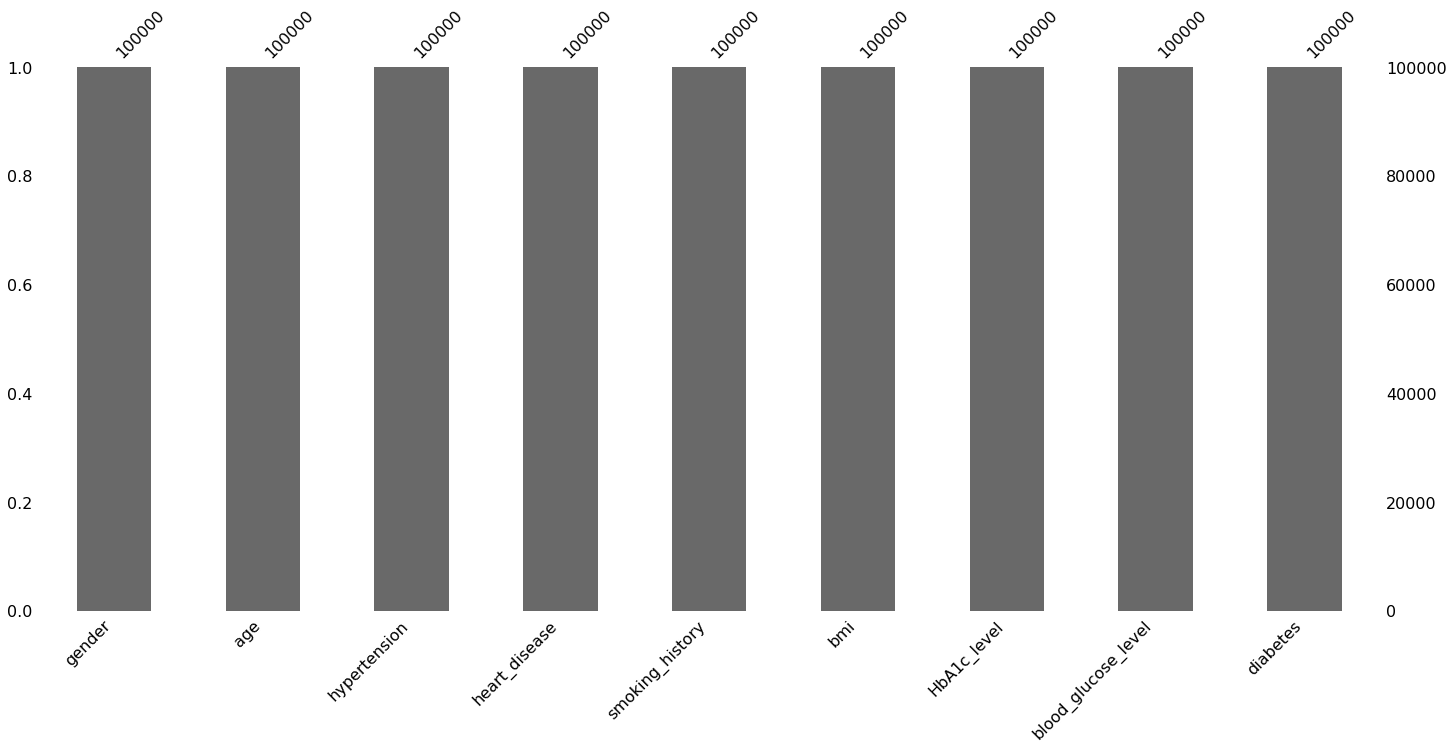

In [5]:
# verify missing data
msno.bar(diabetes_data)

There is no missing data in the data set

### Univariate analysis

In [6]:
# verify data
diabetes_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


Text(0.5, 1.0, 'Count of Smoking History')

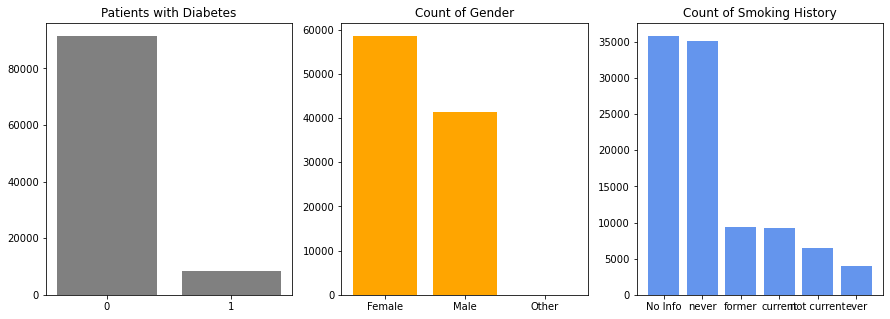

In [7]:
# distribution of categorical variables
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.bar(diabetes_data['diabetes'].astype(str).value_counts().index, diabetes_data['diabetes'].astype(str).value_counts().values, color='gray')
ax1.set_title('Patients with Diabetes')
ax2.bar(diabetes_data['gender'].value_counts().index, diabetes_data['gender'].value_counts().values, color='orange')
ax2.set_title('Count of Gender')
ax3.bar(diabetes_data['smoking_history'].value_counts().index, diabetes_data['smoking_history'].value_counts().values, color='cornflowerblue')
ax3.set_title('Count of Smoking History')

Text(0.5, 1.0, 'Count of Heart Disease')

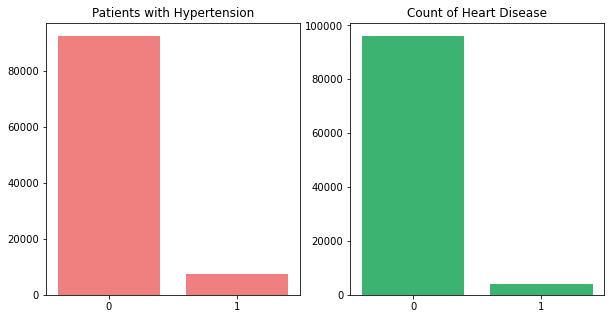

In [8]:
# distribution of categorical variables
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax1.bar(diabetes_data['hypertension'].astype(str).value_counts().index, diabetes_data['hypertension'].astype(str).value_counts().values, color='lightcoral')
ax1.set_title('Patients with Hypertension')
ax2.bar(diabetes_data['heart_disease'].astype(str).value_counts().index, diabetes_data['heart_disease'].astype(str).value_counts().values, color='mediumseagreen')
ax2.set_title('Count of Heart Disease')

Text(0.5, 1.0, 'Distribution of Blood Glucose Level')

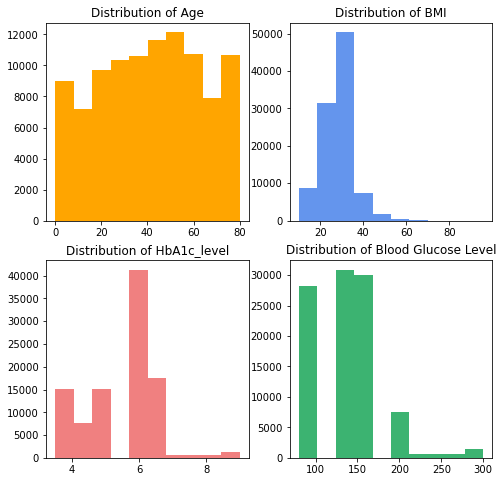

In [9]:
# distribution of numeric variables
fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0, 0].hist(diabetes_data['age'], color='orange')
axs[0, 0].set_title('Distribution of Age')
axs[0, 1].hist(diabetes_data['bmi'], color='cornflowerblue')
axs[0, 1].set_title('Distribution of BMI')
axs[1, 0].hist(diabetes_data['HbA1c_level'], color='lightcoral')
axs[1, 0].set_title('Distribution of HbA1c_level')
axs[1, 1].hist(diabetes_data['blood_glucose_level'], color='mediumseagreen')
axs[1, 1].set_title('Distribution of Blood Glucose Level')

## Data transformation

One Hot Encode (OHE) categorical variables to be used in tree-based models

In [10]:
diabetes_data['gender'].value_counts()

def one_hot_encode(df, colname):
    # copy data
    df_copy = df.copy(deep=True)
    
    # get values of column
    col_vals = list(df_copy[colname].value_counts().index)
    
    for c in col_vals:
        binary_var = []
        
        for i in range(len(df_copy[colname])):
            if df_copy[colname].iloc[i] == c:
                binary_var.append(1)
            else:
                binary_var.append(0)
                
        df_copy[c] = binary_var
        
    return df_copy

In [11]:
diabetes_data = one_hot_encode(diabetes_data, 'gender')
diabetes_data = one_hot_encode(diabetes_data, 'smoking_history')

In [12]:
# verify data transformation
diabetes_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other,No Info,never,former,current,not current,ever
0,Female,80.0,0,1,never,25.19,6.6,140,0,1,0,0,0,1,0,0,0,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,0,1,0,0,1,0,0,0,0
3,Female,36.0,0,0,current,23.45,5.0,155,0,1,0,0,0,0,0,1,0,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,0,1,0,0,0,0,1,0,0


## Modelling

Two tree-based classification models will be tested:
1. Simple decision tree
2. Random forest

Models will be trained and tested using K-Fold cross validation (with 5 folds). Recall will be used as the evaluation criteria, due to the goal of correctly predicting as many true positives as possible. Accuracy will also be documented for reference.

In [13]:
# create list of features and remove target variable
features = list(diabetes_data.columns)
features.remove('diabetes')
features.remove('gender')
features.remove('smoking_history')

In [14]:
# decision tree
dt = DecisionTreeClassifier(
    criterion='gini',    # can choose 'gini' 'entropy' or 'log_loss'
    max_depth=2,        # 2 features for splitting
    max_features=len(features)
)

# K-Fold cross validation with 5 splits
kf = KFold(
    n_splits=5,
    shuffle=False
)

accuracies = []
recalls = []

for train_idx, test_idx in kf.split(diabetes_data):
    train_data = diabetes_data.loc[train_idx]
    test_data = diabetes_data.loc[test_idx]
    
    dt_fit = dt.fit(train_data[features], train_data['diabetes'])
    
    # make predictions
    dt_predictions = dt_fit.predict(test_data[features])
    
    # get model accuracy
    accuracies.append(metrics.accuracy_score(test_data['diabetes'], dt_predictions))
    recalls.append(metrics.recall_score(test_data['diabetes'], dt_predictions))

# get mean of accuracies and recalls
print('Mean accuracy: ', sum(accuracies) / len(accuracies))
print('Mean of recall: ', sum(recalls) / len(recalls))

Mean accuracy:  0.97187
Mean of recall:  0.6693322287971907


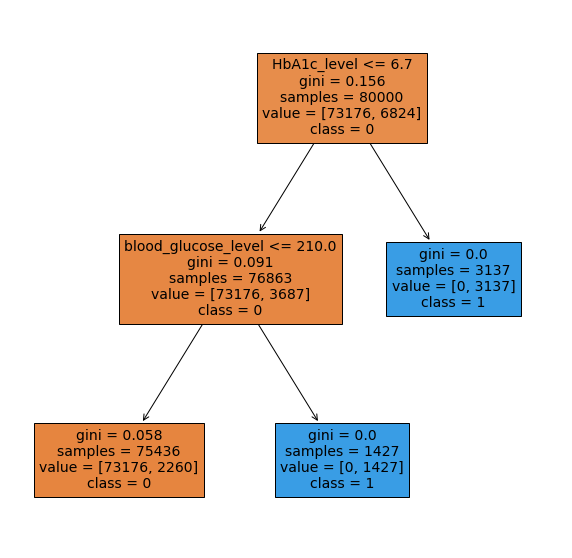

In [15]:
fig = plt.figure(figsize=(10, 10))
tree_viz = tree.plot_tree(dt_fit, 
                          feature_names=features, 
                          class_names=list(pd.Series(diabetes_data['diabetes'].value_counts().index).astype(str)), 
                          filled=True)

In [16]:
# test random forest model
# decision tree
rf = RandomForestClassifier(
    n_estimators=10,    # 10 trees
    criterion='gini',    # can choose 'gini' 'entropy' or 'log_loss'
    max_depth=2,        # 2 features for splitting
    max_features=len(features)
)

accuracies = []
recalls = []

for train_idx, test_idx in kf.split(diabetes_data):
    train_data = diabetes_data.loc[train_idx]
    test_data = diabetes_data.loc[test_idx]
    
    rf_fit = rf.fit(train_data[features], train_data['diabetes'])
    
    # make predictions
    rf_predictions = rf_fit.predict(test_data[features])
    
    # get model accuracy
    accuracies.append(metrics.accuracy_score(test_data['diabetes'], rf_predictions))
    recalls.append(metrics.recall_score(test_data['diabetes'], dt_predictions))

# get mean of accuracies and recalls
print('Mean accuracy: ', sum(accuracies) / len(accuracies))
print('Mean of recall: ', sum(recalls) / len(recalls))

Mean accuracy:  0.97187
Mean of recall:  0.17926045541313976


## Analysis of significant predictors

Text(0.5, 1.0, 'Diabetes vs. HbA1c Level')

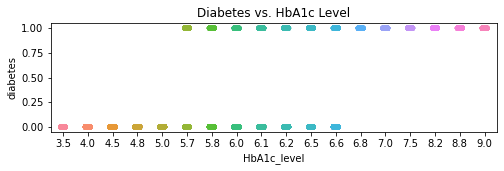

In [17]:
fig = plt.figure(figsize=(8, 2))
sns.stripplot(data=diabetes_data, x='HbA1c_level', y='diabetes')
plt.title('Diabetes vs. HbA1c Level')

Text(0.5, 1.0, 'Diabetes vs. Blood Glucose Level')

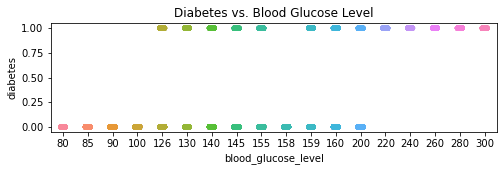

In [18]:
fig = plt.figure(figsize=(8, 2))
sns.stripplot(data=diabetes_data, x='blood_glucose_level', y='diabetes')
plt.title('Diabetes vs. Blood Glucose Level')

## Conclusion

The optimal decision tree has 2 splits:
- If the HbA1c level is greater than 6.7, classify as 'diabetes'
- Else, if the blood glucose level is greater than 210, classify as 'diabetes'
- If neither of the above is true, classify as 'no diabetes'

These splits are confirmed by the jitter plots above. Splitting on the criteria for each variable results in a pure leaf node, where all patients have diabetes. However, the leaf node where a patient has Hba1c and blood glucose levels below the splitting criterion is not pure, meaning there are some patients that have diabetes that were classified as not having diabetes.

The decision tree and random forest both yielded the same average accuracy on 5 splits (for K-Fold cross validation) of approximately 97% accuracy. However, the decision tree had an average recall of ~67%, which is much higher than the random forest's average recall of ~18%. This means the decision tree correctly predicted ~67% of patients who actually had diabetes. For this reason, the recommended model would be the simple decision tree due to having a better recall score. Additionally, the decision tree is more interpretable and requires fewer computations than the random forest.